- 모델을 훈련, 저장하는 과정은 GPU 프리미엄에 고용량 RAM으로 진행하였다 -> 그 후 예측은 CPU로 진행
- 최종 학습 시간 : 약 6시간 20분
- 버전
  - Tensorflow : 2.11.0
  - keras      : 2.11.0
  - np         : 1.22.4
  - DenseNet201

In [ ]:
from tensorflow import keras
import tensorflow as tf

from keras import layers
from keras import models
from keras import optimizers

import matplotlib.pylab as plt
import numpy as np

from google.colab import drive
import os

from keras.applications import densenet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [ ]:
tf.__version__, keras.__version__, np.__version__

('2.11.0', '2.11.0', '1.22.4')

# 데이터 준비

- 데이터는 Aihub에 있는 한국 이미지(음식) 데이터 사용
  - https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=79
  - 기존 데이터는 총 음식 150종, 1종마다 데이터가 1000장씩 있다 (총 150,000장)
  - 이 중 메인메뉴 기준으로 총 음식 26종의 데이터만 사용 (총 26,000장)

- 음식 목록
  - 갈비구이, 고등어구이, 불고기, 삼겹살, 미역국, 양념치킨, 후라이드 치킨, 깍두기, 배추김치, 만두, 라면, 잔치국수, 짜장면, 짬뽕, 떡볶이, 제육볶음, 보쌈, 간장게장, 파전, 김치찌개, 된장찌개, 갈비찜, 계란찜, 족발, 감자탕, 삼계탕

## 공급자 생성

- 데이터의 클래스가 많으므로(26종) 보유한 이미지 양만으로는 성능이 부족할거라 예상
- 과적합 방지 및 성능 개선을 위해 Augmentation 수행

In [ ]:
# 이미지 부풀리기, 공급자 생성
train_datagen = ImageDataGenerator(rescale=1/255,          # 스케일링
                                   rotation_range=20,      # 이미지 회전
                                   width_shift_range=0.2,  # 수직 이동
                                   height_shift_range=0.2, # 수평 이동
                                   horizontal_flip=True,   # 이미지 뒤집기
                                   fill_mode='nearest')    # 이미지가 이동할때 생기는 공백을 근접한 픽셀로 채우기

val_datagen = ImageDataGenerator(rescale=1/255)

## 데이터 준비 및 전처리

In [ ]:
# 데이터 경로
train_path = '/content/drive/MyDrive/cloud_ai/프로젝트3/kfoodsplitcomplete/train'   # 본인의 경로 입력
val_path = '/content/drive/MyDrive/cloud_ai/프로젝트3/kfoodsplitcomplete/val'       # 본인의 경로 입력

train_dir = str(train_path)
val_dir = str(val_path)

In [ ]:
# 이미지 사이즈 지정
image_size = 224

# 공급자의 배치 사이즈 지정
train_batchsize = 100
val_batchsize = 10

# 공급자에 데이터 세팅
train_generator = train_datagen.flow_from_directory(train_dir,
                                                  target_size=(image_size,image_size),
                                                  batch_size=train_batchsize,
                                                  class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(val_dir,
                                                    target_size=(image_size,image_size),
                                                    batch_size=val_batchsize,
                                                    shuffle=True)

Found 23381 images belonging to 26 classes.
Found 2623 images belonging to 26 classes.


In [ ]:
classes = 26     # 클래스 수

# 모델 구축

## 사전 학습 된 모델 불러오기

- DenseNet201 모델 사용

In [ ]:
# densenet 모델 불러오기
dense = densenet.DenseNet201(weights='imagenet',input_shape=(image_size,image_size,3), include_top=False)

74836368/74836368 [==============================] - 5s 0us/step


## 파인튜닝 및 신경망 구성

- Densenet의 2개층만 동결 해제
- 해제된 부분의 파라미터 개수가 너무 많음
- 파라미터 수를 줄이기 위해 BatchNormalization, 및 AveragePooling2D 추가
  - BatchNormalization : 네트워크 안정화, 성능향상, 불안정한 학습 방지
  - AveragePooling2D   : feature map의 크기를 줄여줌

In [ ]:
# 마지막 2개층만 trainable = True로 설정
for layer in dense.layers[:-2]:
  layer.trainable = False
  
for layer in dense.layers:
  print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f9ba651f310> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f9b0cf110d0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9b0cf15100> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9b0cf15f40> False
<keras.layers.core.activation.Activation object at 0x7f9b0cd5b880> False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f9b0cd17190> False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f9b0c5a7820> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9b0c5b1a30> False
<keras.layers.core.activation.Activation object at 0x7f9b0c5a7760> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f9b0cd179a0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f9b0c5b9a60> False
<keras.layers.core.activation.Activation object at 0x7f9b0c5b9fa0> False
<keras.layers.co

In [ ]:
model = models.Sequential()

model.add(dense)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
Total params: 18,321,984
Trainable params: 3,840
Non-trainable params: 18,318,144
_________________________________________________________________


In [ ]:
# 층 구성
model.add(layers.BatchNormalization())
model.add(layers.AveragePooling2D(padding='same'))
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='relu'))        # 활성화함수
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))        # 활성화함수
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes, activation='softmax'))  # softmax : 다중분류
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 7, 7, 1920)        18321984  
                                                                 
 batch_normalization (BatchN  (None, 7, 7, 1920)       7680      
 ormalization)                                                   
                                                                 
 average_pooling2d (AverageP  (None, 4, 4, 1920)       0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense (Dense)               (None, 1024)              31458304  
                                                                 
 batch_normalization_1 (Batc  (None, 1024)             4

## 컴파일

In [ ]:
# 컴파일 구성
model.compile(
  optimizer=optimizers.Adam(learning_rate=0.01), # 최적화 도구
  loss='categorical_crossentropy',               # 손실함수, 평가지표, 값이 0에 가까울수록 좋다
  metrics=['accuracy'])                          # 평가도구 정확도

## CollectBatchStats, ReduceLROnPlateau , 체크포인터 및 Tensorboard 생성

- CollectBatchStats : batch의 손실과 정확도를 저장하기 위한 callback 클래스
- ReduceLROnPlateau : val_loss가 더이상 개선되지 않을 때 learning late를 줄여줌
- 체크포인터        : 모델 가중치를 저장
- Tensorboard       : 훈련 과정을 시각화

In [ ]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    # 그릇 생성
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    #self.batch_acc.append(logs['acc'])

batch_stats = CollectBatchStats()

In [ ]:
reducelr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)

In [ ]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='/content/drive/MyDrive/cloud_ai/프로젝트3/이미지분류저장/weights.hdf5', verbose=1, save_best_only=True)  # 본인의 경로 입력

In [ ]:
board = tf.keras.callbacks.TensorBoard(log_dir='/content/gdrive/My Drive/tensorboard/logs',  # 본인의 경로 입력
                            histogram_freq=0,
                            write_graph=True, 
                            write_grads=False, 
                            write_images=False, 
                            embeddings_freq=0, 
                            embeddings_layer_names=None, 
                            embeddings_metadata=None, 
                            embeddings_data=None, 
                            update_freq='epoch')

## 훈련

In [ ]:
# 모델 훈련 -> 최종 학습 시간 : 
history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=32,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // val_batchsize,
                    verbose=1,
                    callbacks=[batch_stats, checkpointer, board]
                    )

Epoch 1/32
  5/100 [>.............................] - ETA: 1:36:08 - loss: 4.6580 - accuracy: 0.1640

/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


100/100 [==============================] - ETA: 0s - loss: 2.5785 - accuracy: 0.4787  
Epoch 1: val_loss improved from inf to 2.56931, saving model to /content/drive/MyDrive/cloud_ai/프로젝트3/이미지분류저장/weights.hdf5
100/100 [==============================] - 8162s 82s/step - loss: 2.5785 - accuracy: 0.4787 - val_loss: 2.5693 - val_accuracy: 0.5844
Epoch 2/32
100/100 [==============================] - ETA: 0s - loss: 1.4397 - accuracy: 0.6397 
Epoch 2: val_loss improved from 2.56931 to 0.91944, saving model to /content/drive/MyDrive/cloud_ai/프로젝트3/이미지분류저장/weights.hdf5
100/100 [==============================] - 3690s 37s/step - loss: 1.4397 - accuracy: 0.6397 - val_loss: 0.9194 - val_accuracy: 0.7412
Epoch 3/32
100/100 [==============================] - ETA: 0s - loss: 1.0846 - accuracy: 0.6948 
Epoch 3: val_loss improved from 0.91944 to 0.77406, saving model to /content/drive/MyDrive/cloud_ai/프로젝트3/이미지분류저장/weights.hdf5
100/100 [=======================

# 모델 저장

In [ ]:
# 모델 저장
import h5py
model.save('/content/drive/MyDrive/cloud_ai/프로젝트3/이미지분류저장/densenet_Adam.h5')  # 본인의 경로 입력

# 저장된 모델 로드

In [ ]:
#학습된 모델 로드
model2 = keras.models.load_model('/content/drive/MyDrive/cloud_ai/프로젝트3/이미지분류저장/densenet_Adam.h5')  # 본인의 경로 입력

In [ ]:
# 모델 로드부터만 실행 하려면 밑의 주석 부분 실행해야함

# val_datagen = ImageDataGenerator(rescale=1/255)

# val_path = '/content/drive/MyDrive/cloud_ai/프로젝트3/kfoodsplitcomplete/val'   # 본인의 경로 입력
# val_dir = str(val_path)

# image_size = 224

# val_batchsize = 10


# validation_generator = val_datagen.flow_from_directory(val_dir,
#                                                     target_size=(image_size,image_size),
#                                                     batch_size=val_batchsize,
#                                                     shuffle=True)

Found 2623 images belonging to 26 classes.


# 로드된 모델로 예측 수행

In [ ]:
# 사용자한테 입력 받는 부분

image_name = input("사진 이름을 적어주세요 :  ")

사진 이름을 적어주세요 :  Img_122_0220.jpg


In [ ]:
#분류할 이미지의 경로
image_path = '/content/drive/MyDrive/cloud_ai/프로젝트3/kfoodsplitcomplete/val/된장찌개/'   # 본인의 경로 입력
image = image_path + image_name

In [ ]:
#이미지를 모델이 예측 가능하도록 가공
x = keras.preprocessing.image.load_img(image, target_size=(224,224))
x1 = keras.preprocessing.image.img_to_array(x)
x = np.expand_dims(x1, axis=0)

In [ ]:
#예측
result = model2.predict(x)

1/1 [==============================] - 4s 4s/step


In [ ]:
#목록 클래스 라벨화 후 정렬
label_names = sorted(validation_generator.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])

In [ ]:
#결과값을 음식으로 맵핑시켜 초기화
result_label = label_names[np.argmax(result)]

된장찌개


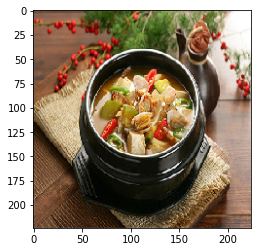

In [ ]:
# 예측한 값 출력
print(result_label)

# 이미지 출력
result_img = keras.preprocessing.image.array_to_img(x1)
plt.imshow(result_img)